In [4]:
from bs4 import BeautifulSoup
import pandas as pd

# Read the KML file
with open("D:\Batavia\SEM 2026\Visualisasi Map dengan Phyton\mandalika.kml", "r", encoding="utf-8") as f:
    kml_text = f.read()

soup = BeautifulSoup(kml_text, "xml")

# Get the <coordinates> element from the LineString
#    (if there are multiple, this takes the first one)
coords_tag = soup.find("coordinates")
coords_str = coords_tag.string.strip()

# Split the coordinate string into lon, lat, alt
points = []
for chunk in coords_str.split():
    lon_str, lat_str, *rest = chunk.split(",")
    lon = float(lon_str)
    lat = float(lat_str)
    points.append((lat, lon))

# Save to CSV
df = pd.DataFrame(points, columns=["lat", "lon"])
df.to_csv("mandalikaa.csv", index=False)

print("Saved: mandalikaa.csv with", len(df), "points")

Saved: mandalikaa.csv with 718 points


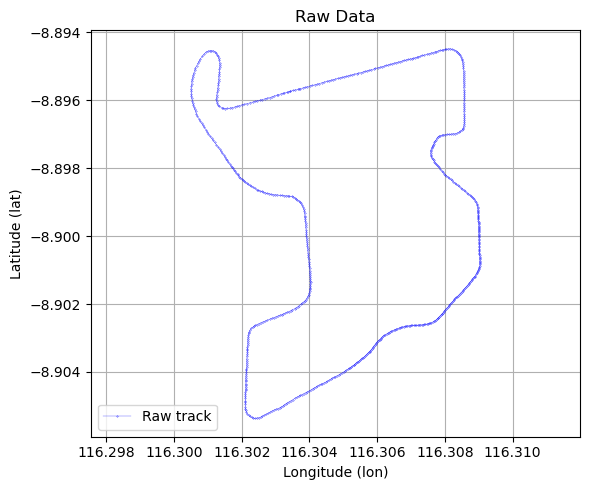

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Read raw track from the cleaned file
df = pd.read_csv("mandalikaa.csv")

lat_raw = df["lat"].values
lon_raw = df["lon"].values

plt.figure(figsize=(6, 5))

# Blue dots connected by thin line
plt.plot(lon_raw, lat_raw, "b.-", markersize=0.5, linewidth=0.2, label="Raw track")

plt.xlabel("Longitude (lon)")
plt.ylabel("Latitude (lat)")
plt.title("Raw Data")
plt.grid(True)
plt.axis("equal")
plt.legend()

plt.tight_layout()

plt.savefig(
    "raw_track_mandalika.png",   # output filename
    dpi=600,              # high resolution
    bbox_inches="tight",  # trim extra white space
    pad_inches=0.05       # small padding
)

plt.show()


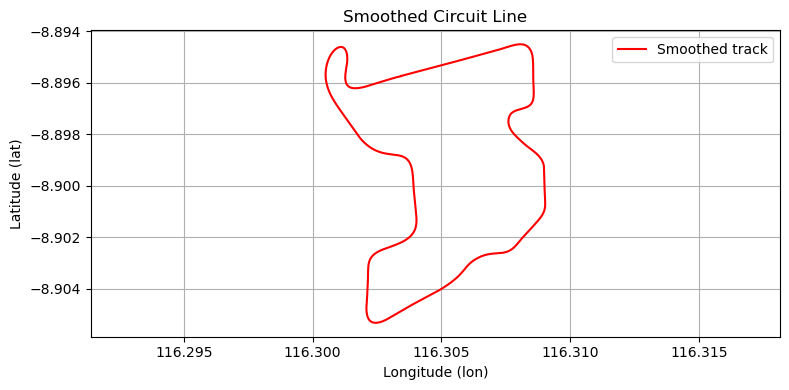

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import numpy as np

# Read raw track
df = pd.read_csv("mandalikaa.csv")
lat_raw = df["lat"].values
lon_raw = df["lon"].values

# Smooth the track
N = len(lat_raw)
window_length = min(31, N - (1 - N % 2)) 
polyorder = 3

lat_smooth = savgol_filter(lat_raw, window_length=window_length, polyorder=polyorder)
lon_smooth = savgol_filter(lon_raw, window_length=window_length, polyorder=polyorder)

# Save smoothed data to CSV
df_smooth = pd.DataFrame({
    "lat_raw":    lat_raw,
    "lon_raw":    lon_raw,
    "lat_smooth": lat_smooth,
    "lon_smooth": lon_smooth,
})
df_smooth.to_csv("mandalika_smoothed_track.csv", index=False)

plt.figure(figsize=(8, 4))

plt.plot(
    lon_smooth,
    lat_smooth,
    color="r",
    linestyle="-",
    linewidth=1.5,
    label="Smoothed track"
)

plt.xlabel("Longitude (lon)")
plt.ylabel("Latitude (lat)")
plt.title("Smoothed Circuit Line")
plt.grid(True)
plt.axis("equal")
plt.legend()

plt.tight_layout()

plt.savefig(
    "mandalika_smoothed_track.png",
    dpi=600,
    bbox_inches="tight",
    pad_inches=0.05
)

plt.show()

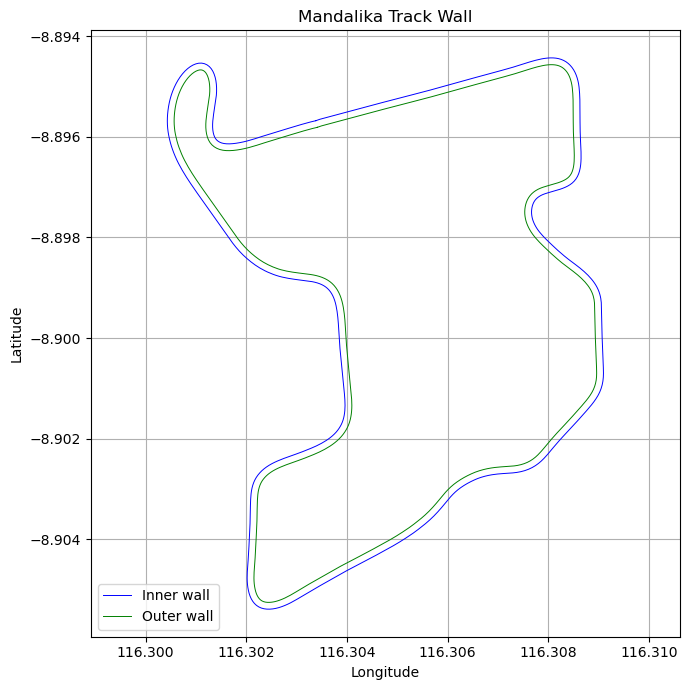

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load smoothed centerline
df = pd.read_csv("mandalika_smoothed_track.csv")   # lat_smooth, lon_smooth
lat_s = df["lat_smooth"].values
lon_s = df["lon_smooth"].values

# 2) Compute walls from centerline
track_width = 15          # meters
meters_per_deg = 111_000.0 # approx m per degree

dx = np.diff(lon_s)
dy = np.diff(lat_s)
L  = np.sqrt(dx**2 + dy**2)

ux = dx / L
uy = dy / L
nx = -uy
ny = ux

lon_c = (lon_s[:-1] + lon_s[1:]) / 2
lat_c = (lat_s[:-1] + lat_s[1:]) / 2

offset_deg = (track_width / 2) / meters_per_deg

lon_inner = lon_c - nx * offset_deg
lat_inner = lat_c - ny * offset_deg
lon_outer = lon_c + nx * offset_deg
lat_outer = lat_c + ny * offset_deg

# 3) Save walls CSV 
track_wall = pd.DataFrame({
    "seg_index":  np.arange(len(lat_c)),
    "lat_center": lat_c,
    "lon_center": lon_c,
    "lat_inner":  lat_inner,
    "lon_inner":  lon_inner,
    "lat_outer":  lat_outer,
    "lon_outer":  lon_outer,
})
track_wall.to_csv("mandalika_track_wall.csv", index=False)

# 4) CLOSE THE LOOP
lon_inner_closed = np.r_[lon_inner, lon_inner[0]]
lat_inner_closed = np.r_[lat_inner, lat_inner[0]]
lon_outer_closed = np.r_[lon_outer, lon_outer[0]]
lat_outer_closed = np.r_[lat_outer, lat_outer[0]]

# 5) Plot closed walls save HD PNG
plt.figure(figsize=(7, 7))
plt.plot(lon_inner_closed, lat_inner_closed, "b-", linewidth=0.7, label="Inner wall")
plt.plot(lon_outer_closed, lat_outer_closed, "g-", linewidth=0.7, label="Outer wall")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Mandalika Track Wall")
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.savefig("mandalika_track_walls.png", dpi=600, bbox_inches="tight", pad_inches=0.05)
plt.show()

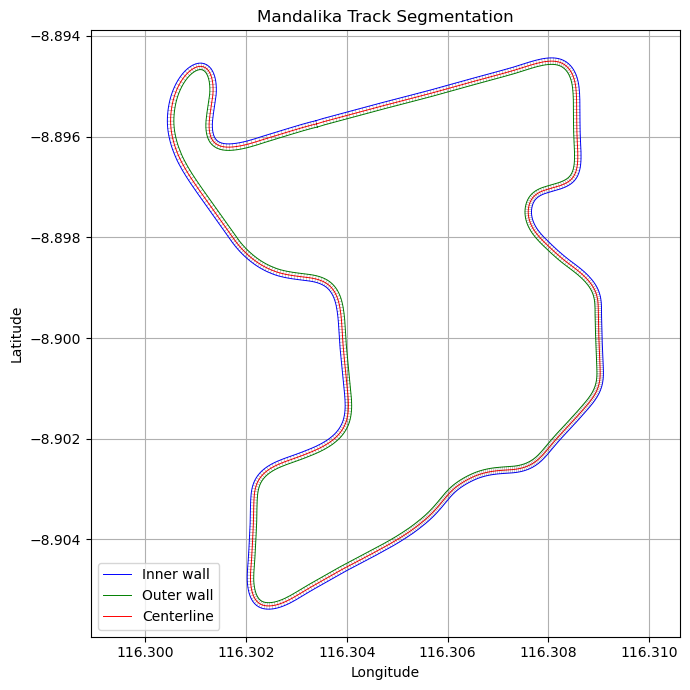

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load walls + centerline
wall = pd.read_csv("D:\Batavia\SEM 2026\mandalika_track_wall.csv")
lat_inner = wall["lat_inner"].values
lon_inner = wall["lon_inner"].values
lat_outer = wall["lat_outer"].values
lon_outer = wall["lon_outer"].values
lat_center = wall["lat_center"].values
lon_center = wall["lon_center"].values

# 2) Build segmentation lines between inner & outer
n_seg = 20  # points from inner to outer per segment

seg_lon_list = []
seg_lat_list = []
seg_idx_list = []

for k, (la_i, lo_i, la_o, lo_o) in enumerate(
        zip(lat_inner, lon_inner, lat_outer, lon_outer)):
    seg_lat = np.linspace(la_i, la_o, n_seg)
    seg_lon = np.linspace(lo_i, lo_o, n_seg)
    for j in range(n_seg):
        seg_lat_list.append(seg_lat[j])
        seg_lon_list.append(seg_lon[j])
        seg_idx_list.append(k)

# 3) Save segmentation CSV
track_seg = pd.DataFrame({
    "seg_index": seg_idx_list,
    "lat_seg":   seg_lat_list,
    "lon_seg":   seg_lon_list,
})
track_seg.to_csv("mandalika_track_segmentation.csv", index=False)

# 4) Plot walls + segmentation grid + centerline, then save PNG
plt.figure(figsize=(7, 7))

plt.plot(lon_inner,  lat_inner,  "b-", linewidth=0.7, label="Inner wall")
plt.plot(lon_outer,  lat_outer,  "g-", linewidth=0.7, label="Outer wall")
plt.plot(lon_center, lat_center, "r-", linewidth=0.7, label="Centerline")

for k in range(len(lat_inner)):
    la_i, lo_i = lat_inner[k], lon_inner[k]
    la_o, lo_o = lat_outer[k], lon_outer[k]
    seg_lat = np.linspace(la_i, la_o, n_seg)
    seg_lon = np.linspace(lo_i, lo_o, n_seg)
    plt.plot(seg_lon, seg_lat, "k-", linewidth=0.3, alpha=0.5)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Mandalika Track Segmentation")
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.savefig("mandalika_track_segmentation.png", dpi=600,
            bbox_inches="tight", pad_inches=0.05)
plt.show()

C:\Users\Acer\AppData\Local\Temp\ipykernel_6008\985978187.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("jet")  # blue -> cyan -> yellow -> red


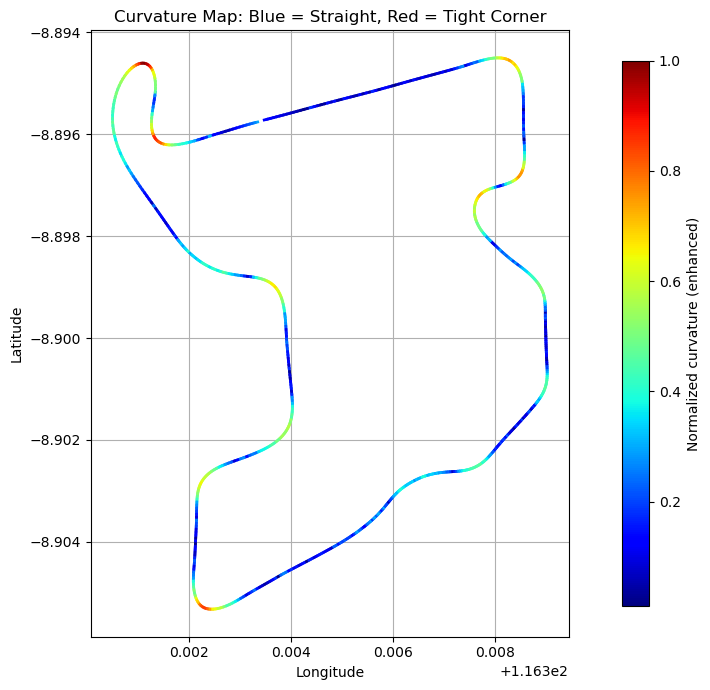

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# 1) Load smoothed track
clean = pd.read_csv("mandalika_smoothed_track.csv")
lat = clean["lat_smooth"].values
lon = clean["lon_smooth"].values

# 2) Compute heading and curvature
dx = np.diff(lon)
dy = np.diff(lat)
heading = np.arctan2(dy, dx)

d_heading = np.diff(heading)
d_heading = (d_heading + np.pi) % (2 * np.pi) - np.pi

curv = np.abs(d_heading)
curv_norm = curv / curv.max()
curv_norm = curv_norm**0.5   # more sensitive in corners

# midpoints for drawing colored segments
lon_mid = (lon[1:-1] + lon[2:]) / 2
lat_mid = (lat[1:-1] + lat[2:]) / 2

# 3) Plot curvature map
fig, ax = plt.subplots(figsize=(7.5, 7))

cmap = plt.cm.get_cmap("jet")  # blue -> cyan -> yellow -> red

for i in range(len(lon_mid) - 1):
    c = cmap(curv_norm[i])
    ax.plot(
        [lon_mid[i], lon_mid[i+1]],
        [lat_mid[i], lat_mid[i+1]],
        color=c,
        linewidth=2,
    )

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Curvature Map: Blue = Straight, Red = Tight Corner")
ax.grid(True)
ax.set_aspect("equal", adjustable="box")

# colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap)
sm.set_array(curv_norm)
cbar = plt.colorbar(sm, ax=ax, shrink=0.9, pad=0.08)
cbar.set_label("Normalized curvature (enhanced)")

plt.tight_layout()

plt.savefig(
    "mandalika track_curvature.png",
    dpi=600,
    bbox_inches="tight",
    pad_inches=0.05
)

plt.show()